# LENS ANTI_DISTORTION

Основано на данных работах: <br>
>[fisheyegl](https://github.com/jywarren/fisheyegl) <br>
>[iFish](https://github.com/Gil-Mor/iFish)


In [1]:
import imageio.v2 as imageio
import numpy as np
from math import sqrt
import sys
import argparse
import os
from  matplotlib import pyplot as plt
from PIL import Image
import cv2



In [2]:
def get_fish_xn_yn(source_x, source_y, radius, x_distortion, y_distortion):
    """
    Функция перерасчета положений пикселей:
    
    source_x: исходная координата x пикселя в исходном изображении. Это значение должно быть в диапазоне от 0 до ширины исходного изображения.
    source_y: исходная координата y пикселя в исходном изображении. Это значение должно быть в диапазоне от 0 до высоты исходного изображения.
    radius: радиус линзы в пикселях. Это значение определяет, насколько сильно будут искажаться пиксели в зависимости от того, насколько они находятся от центра линзы.
    x_distortion: параметр искажения по оси x. Чем больше это значение, тем сильнее пиксели будут смещаться относительно центра изображения.
    y_distortion: параметр искажения по оси y. Чем больше это значение, тем сильнее пиксели будут смещаться относительно центра изображения.

    Функция возвращает нормализованные координаты x и y пикселя в искаженном изображении. 
    PS: эти координаты также могут быть за пределами границ искаженного изображения.
    """
    
    if 1 - x_distortion*(radius**2) == 0 :
        xn = source_x
    else:
        xn = source_x / (1 - (x_distortion*(radius**2)))
        
    if 1 - y_distortion*(radius**2) == 0:
        yn = source_y
    else:
        yn = source_y / (1 - (y_distortion*(radius**2)))
    return xn, yn


def fish(img, x_distortion, y_distortion, scale_x=1, scale_y=1):
    """
    :type img: numpy.ndarray
    :param distortion_coefficient: The amount of distortion to apply.
    :return: numpy.ndarray - the image with applied effect.
    """

    # Сохраним значения высоты и ширины исходного изображения
    w, h = img.shape[0], img.shape[1]
    w, h = float(w), float(h)

    # Для чб изображений сделаем копирование исходного канала 2 раза (h,w)->(h,w,3)
    if len(img.shape) == 2:
        bw_channel = np.copy(img)
        img = np.dstack((img, bw_channel))
        img = np.dstack((img, bw_channel))

    # Создадим массив нулей который будем перезаписывать в процессе выполнения функции
    dstimg = np.zeros_like(img)

    # easier calcultion if we traverse x, y in dst image
    for x in range(len(dstimg)):
        for y in range(len(dstimg[x])):

            # normalize x and y to be in interval of [-1, 1]
            xnd, ynd = float((2*x - w)/w), float((2*y - h)/h)

            # get xn and yn distance from normalized center
            rd = sqrt(xnd**2 + ynd**2)

            # new normalized pixel coordinates
            xdu, ydu = get_fish_xn_yn(xnd, ynd, rd, x_distortion, y_distortion)

            # Добавление рескейлинга по осям (a, b параметры в линзе)
            xdu, ydu = xdu * scale_y, ydu * scale_x

            # convert the normalized distorted xdn and ydn back to image pixels
            xu, yu = int(((xdu + 1)*w)/2), int(((ydu + 1)*h)/2)


            # if new pixel is in bounds copy from source pixel to destination pixel
            if 0 <= xu and xu < img.shape[0] and 0 <= yu and yu < img.shape[1]:
                dstimg[x][y] = img[xu][yu]
    
    return dstimg.astype(np.uint8)


In [3]:
def plot_result(img, output_img):
    plt.figure(figsize=[12, 12])
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Исходное изображение')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(output_img)
    plt.title('Результат обработки')
    plt.axis('off')
    plt.show()

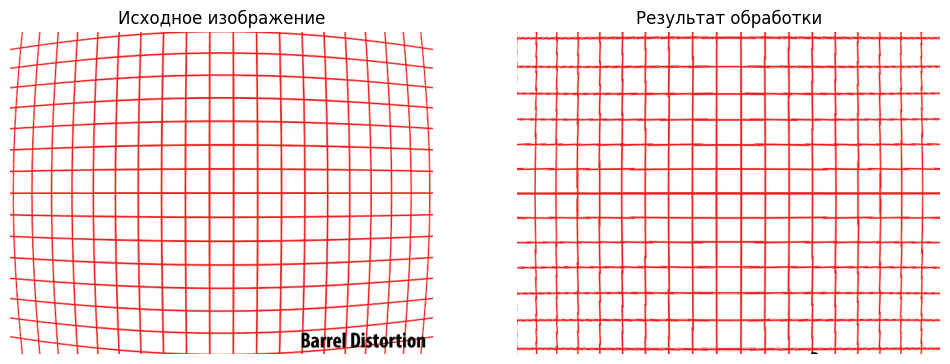

In [4]:
img = imageio.imread("images/grid.png")
output_img = fish(img, -0.12, -0.025)  # Идеальные параметры
plot_result(img, output_img)

Пример с добавлением в функцию значений рескейлинга по оси x и y:

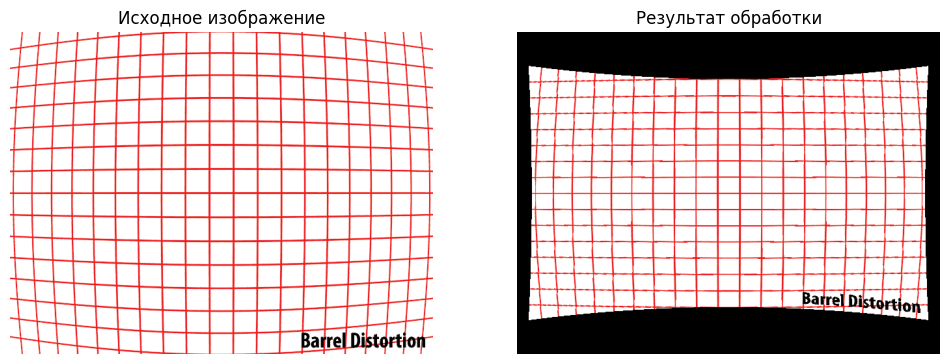

In [21]:
img = imageio.imread("images/grid.png")
output_img = fish(img, -0.12, -0.025, scale_x=1.1, scale_y=1.5)  # Идеальные параметры
plot_result(img, output_img)

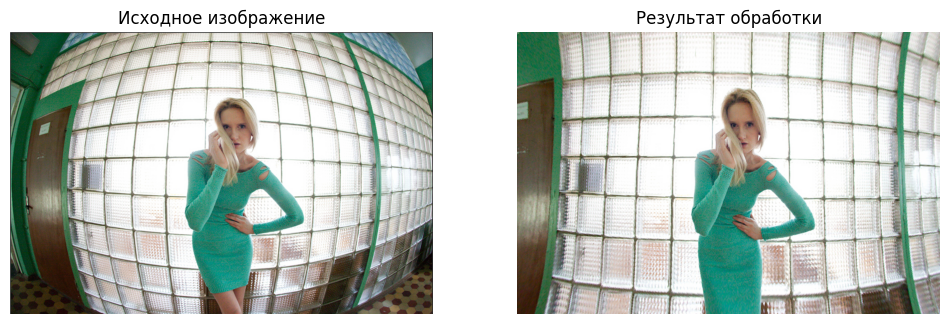

In [5]:
img = imageio.imread("images/wide_angle_camera.png")
output_img = fish(img, -0.35, -0.15)
plot_result(img, output_img)

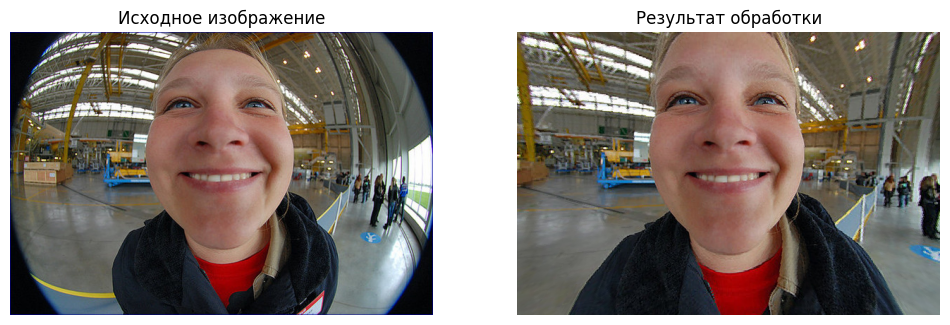

In [6]:
img = imageio.imread("images/fish_eye.jpg")
output_img = fish(img, -0.2, -0.3)
plot_result(img, output_img)

__Попытка создать интерактивное окно с возможность менять параметры y_distortion и x_distortion в реальном времени:__

In [7]:
def interctive_window(path, make_distortion=False):
    '''
    Функция для постройки интерактивного окна с возможностью подбирать коэффициенты для дисторсии с помощью слайдера
    На вход подается путь к файлу (исходное изображение)
    make_distortion = False -> коэффициенты со знаком - чтобы делать антидисторсию
    make_distortion = True -> коэффициенты со знаком + чтобы делать создать дисторсию
    '''
    import cv2
    import imageio.v2 as imageio
    import numpy as np
    
    def img_intensity_change_x(x):            
        pass
    def img_intensity_change_y(y):            
        pass
    
    # Считаем изображение:
    img = imageio.imread(path)
    cv2.namedWindow('LENS DISTORTION')
    val = -1 # переменная для хранения знака + или - для коэффициентов
    # Создадим sliders:
    cv2.createTrackbar('value x', 'LENS DISTORTION', 0, 20, img_intensity_change_x)
    cv2.createTrackbar('value y', 'LENS DISTORTION', 0, 20, img_intensity_change_y)

    while(1):
        # Считаем данные со слайдера:
        x = cv2.getTrackbarPos('value x', 'LENS DISTORTION')
        y = cv2.getTrackbarPos('value y', 'LENS DISTORTION')
        # Переведем в значения меньшего диапазона и со знаком 
        if make_distortion:
            val = 1  # Поменяет знак на + при входе в функцию
        joint_1 = x * 0.05 * val
        joint_2 = y * 0.05 * val
        output_img = fish(img, joint_1, joint_2)
        output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
        cv2.putText(output_img, 'x_distortion:'+str(joint_1), (20, 20), fontFace=2, fontScale=1, color=(0, 0, 220), thickness=2 )
        cv2.putText(output_img, 'y_distortion:'+str(joint_2), (20, 60), fontFace=2, fontScale=1, color=(0, 0, 220), thickness=2 )
        cv2.imshow('LENS DISTORTION',output_img)    
        # Обновление каждый 10 мс пока не нажмется кнопка закрытие окна
        if cv2.waitKey(10) == ord('q'):
            break
        
    cv2.destroyAllWindows()

Пример функций для создания интерактивного окна для выполнения процедуры антидисторсии для фотографии:

In [10]:
#interctive_window("images/wide_angle_camera.png")

Пример функций для создания интерактивного окна для выполнения процедуры добавления абберации дисторсии для фотографии:

In [11]:
#interctive_window("images/no_distortion.jpg", make_distortion=True)